In [0]:
import numpy as np
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
import math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from tqdm import tqdm
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
import pickle
import scipy
import scipy.sparse
from scipy.sparse import hstack
from scipy.stats import uniform
from scipy.stats import randint as sp_randint

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt

In [0]:
os.chdir("/content/drive/My Drive/Case Study I")

In [0]:
data = pd.read_csv('train.tsv',sep = '\t')
train,test = train_test_split(data,test_size = 0.25)
print("Train Data Shape : ",train.shape)
print("Test Data Shape : ",test.shape)

Train Data Shape :  (1111901, 8)
Test Data Shape :  (370634, 8)


Mercari App doesn't allows price to be lower than 3 and greater than 2000

In [0]:
# Reference : https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755

train = train[(train.price >=3) & (train.price <= 2000)]
train.shape

(1111239, 8)

In [0]:
# Reference : Applied AI Course

def decontracted(phrase):
  # specific
  phrase = re.sub(r"won't", "will not", phrase)
  phrase = re.sub(r"can\'t", "can not", phrase)
  # general
  phrase = re.sub(r"n\'t", " not", phrase)
  phrase = re.sub(r"\'re", " are", phrase)
  phrase = re.sub(r"\'s", " is", phrase)
  phrase = re.sub(r"\'d", " would", phrase)
  phrase = re.sub(r"\'ll", " will", phrase)
  phrase = re.sub(r"\'t", " not", phrase)
  phrase = re.sub(r"\'ve", " have", phrase)
  phrase = re.sub(r"\'m", " am", phrase)

  return phrase

In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
stop_words = stopwords.words('english')
def preprocessing_text(text):
  preprocessed_text = []
  for sentence in tqdm(text.values):
    sentence = decontracted(sentence)
    sent = sentence.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = ' '.join(e for e in sent.split() if e not in stop_words)
    preprocessed_text.append(sent.lower().strip())
  return preprocessed_text

### Filling Missing Entries in Name and Description

In [0]:
train['name'] = train['name'].replace([np.nan], '')
test['name'] = test['name'].replace([np.nan], '')

train['item_description'] = train['item_description'].replace([np.nan], '')
test['item_description'] = test['item_description'].replace([np.nan], '')

In [0]:
train['preprocess_name'] = preprocessing_text(train['name'])
test['preprocess_name'] = preprocessing_text(test['name'])

train['preprocess_desc'] = preprocessing_text(train['item_description'])
test['preprocess_desc'] = preprocessing_text(test['item_description'])

100%|██████████| 370634/370634 [00:25<00:00, 14698.86it/s]


### Encoding Name and Descrption in BOW

In [0]:
# Vectorizer = CountVectorizer(ngram_range=(1,4),min_df=25,max_features=50000)
# Vectorizer.fit(train['preprocess_name'].values)

# train_name_bow = Vectorizer.transform(train['preprocess_name'].values)
# test_name_bow = Vectorizer.transform(test['preprocess_name'].values)

# print("After Vectorization :")
# print(train_name_bow.shape)
# print(test_name_bow.shapea)

After Vectorization :
(1111264, 31809)
(370634, 31809)


In [0]:
# Vectorizer = CountVectorizer(ngram_range=(1,3),min_df=30,max_features=100000)
# Vectorizer.fit(train['preprocess_desc'].values)

# train_desc_bow = Vectorizer.transform(train['preprocess_desc'].values)
# test_desc_bow = Vectorizer.transform(test['preprocess_desc'].values)



In [0]:
print("After Vectorization :")
print(train_desc_bow.shape)
print(test_desc_bow.shape)

After Vectorization :
(1111264, 100000)
(370634, 100000)


In [0]:
# file = open("train_name_bow","wb")
# pickle.dump(train_name_bow,file)
# file.close()

# file = open("test_name_bow","wb")
# pickle.dump(test_name_bow,file)
# file.close()

# file = open("train_desc_bow","wb")
# pickle.dump(train_desc_bow,file)
# file.close()

# file = open("test_desc_bow","wb")
# pickle.dump(test_desc_bow,file)
# file.close()

### Encoding Brand Name

In [0]:
# First Fill all the Missing Brand Name with value "missing"

train["brand_name"] = train["brand_name"].fillna("missing").astype("category")
test["brand_name"] = test["brand_name"].fillna("missing").astype("category")

In [0]:
LabelEncoder = LabelBinarizer(sparse_output=True)
LabelEncoder.fit(train['brand_name'].values)

train_brand = LabelEncoder.transform(train['brand_name'].values)
test_brand = LabelEncoder.transform(test['brand_name'].values)

print(train_brand.shape)
print(test_brand.shape)

(1111239, 4440)
(370634, 4440)


### Encoding Category_Name

In [0]:
# Fill all the Missing Value with value "missing"

train["category_name"] = train["category_name"].fillna("missing").astype("category")
test["category_name"] = test["category_name"].fillna("missing").astype("category")

In [0]:
# First We will find all the Unique Values in the Category Name
# Then we will one hot encode it using CountVectorizer

unique_value = pd.Series("/".join(train["category_name"].unique().astype("str")).split("/")).unique()

Vectorizer = CountVectorizer(vocabulary=unique_value,lowercase = False, binary = True)
Vectorizer.fit(train['category_name'].values)

train_category_name = Vectorizer.transform(train['category_name'].values)
test_category_name = Vectorizer.transform(test['category_name'].values)

print(train_category_name.shape)
print(test_category_name.shape)

(1111239, 937)
(370634, 937)


### Encoding Shipping and Item_Category_ID

In [0]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1111245 entries, 801206 to 98107
Data columns (total 10 columns):
 #   Column             Non-Null Count    Dtype   
---  ------             --------------    -----   
 0   train_id           1111245 non-null  int64   
 1   name               1111245 non-null  object  
 2   item_condition_id  1111245 non-null  int64   
 3   category_name      1111245 non-null  category
 4   brand_name         1111245 non-null  category
 5   price              1111245 non-null  float64 
 6   shipping           1111245 non-null  int64   
 7   item_description   1111245 non-null  object  
 8   preprocess_name    1111245 non-null  object  
 9   preprocess_desc    1111245 non-null  object  
dtypes: category(2), float64(1), int64(3), object(4)
memory usage: 80.8+ MB


In [0]:
# In order to One Hot Encode Shipping and Item Condition ID 
# we need to convert it from int64 to category

train['item_condition_id'] = train['item_condition_id'].astype('category')
test['item_condition_id'] = test['item_condition_id'].astype('category')

train['shipping'] = train['shipping'].astype('category')
test['shipping'] = test['shipping'].astype('category')

In [0]:
train_dummies = scipy.sparse.csr_matrix(pd.get_dummies(train[["item_condition_id", "shipping"]], sparse = True).values)
test_dummies = scipy.sparse.csr_matrix(pd.get_dummies(test[["item_condition_id", "shipping"]], sparse = True).values)

print(train_dummies.shape)
print(test_dummies.shape)

(1111239, 7)
(370634, 7)


Saving everything into pickle files

In [0]:
# file = open("train_brand","wb")
# pickle.dump(train_brand,file)
# file.close()

# file = open("test_brand","wb")
# pickle.dump(test_brand,file)
# file.close()

# file = open("train_category_name","wb")
# pickle.dump(train_category_name,file)
# file.close()

# file = open("test_category_name","wb")
# pickle.dump(test_category_name,file)
# file.close()

# file = open("train_dummies","wb")
# pickle.dump(train_dummies,file)
# file.close()

# file = open("test_dummies","wb")
# pickle.dump(test_dummies,file)
# file.close()

### Transforming Price into Log Price

In [0]:
# Transforming price -> log(1 + price)
train['log_price'] = np.log1p(train['price'])
test['log_price'] = np.log1p(test['price'])

In [0]:
train.columns

Index(['train_id', 'name', 'item_condition_id', 'category_name', 'brand_name',
       'price', 'shipping', 'item_description', 'preprocess_name',
       'preprocess_desc', 'log_price'],
      dtype='object')

In [0]:
# Taking out the Log Price from input Data

y_train_tfidf = train['log_price'].values
y_test_tfidf = test['log_price'].values

print(y_train_tfidf.shape)
print(y_test_tfidf.shape)

(1111239,)
(370634,)


In [0]:
# file = open("y_train","wb")
# pickle.dump(y_train,file)
# file.close()

# file = open("y_test","wb")
# pickle.dump(y_test,file)
# file.close()

In [0]:
file = open("y_train","rb")
y_train = pickle.load(file)
file.close()

file = open("y_test","rb")
y_test = pickle.load(file)
file.close()

## Concatenating All the Features

In [0]:
X_train = hstack((train_name_bow,train_desc_bow,train_brand,train_category_name,
                  train_dummies)).tocsr().astype('float32')
X_test = hstack((test_name_bow,test_desc_bow,test_brand,test_category_name,
                  test_dummies)).tocsr().astype('float32')

print("X_train Shape : ",X_train.shape)
print("y_train Shape : ",y_train.shape)
print("X_test Shape : ",X_test.shape)
print("y_test Shape : ",y_test.shape)

X_train Shape :  (1111264, 137231)
y_train Shape :  (1111264,)
X_test Shape :  (370634, 137231)
y_test Shape :  (370634,)


In [0]:
# file = open("X_train","wb")
# pickle.dump(X_train,file)
# file.close()

# file = open("X_test","wb")
# pickle.dump(X_test,file)
# file.close()

In [0]:
file = open("X_train","rb")
X_train = pickle.load(file)
file.close()

file = open("X_test","rb")
X_test = pickle.load(file)
file.close()

### Defining RMSLE and RMSE

In [0]:
# Reference : https://www.kaggle.com/c/ashrae-energy-prediction/discussion/113064

def rmsle_score(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [0]:
# Reference : https://github.com/microsoft/LightGBM/blob/master/examples/python-guide/sklearn_example.py

def rmsle_lgb(y,y_pred):
  return "RMSLE",rmsle_score(y,y_pred),False

In [0]:
def rmse_score(y,y_pred):
  return math.sqrt(mean_squared_error(y, y_pred))

## ML Models

1. Ridge Regressor

In [0]:
model = Ridge(solver = "lsqr", fit_intercept=False)
model.fit(X_train, y_train)
y_pred = np.expm1(model.predict(X_test))

train_rmsle = rmsle_score(np.expm1(y_train),np.expm1(model.predict(X_train)))
test_rmsle = rmsle_score(np.expm1(y_test),y_pred)

train_rmse = rmse_score(np.expm1(y_train),np.expm1(model.predict(X_train)))
test_rmse = rmse_score(np.expm1(y_test),y_pred)

print("Train RMSLE : ",train_rmsle)
print("Test RMSLE : ",test_rmsle)

print("Train RMSE : ",train_rmse)
print("Test RMSE : ", test_rmse)

Train RMSLE :  0.44003012448031376
Test RMSLE :  0.474994210960136
Train RMSE :  33.78192294209455
Test RMSE :  34.283177450734854


### Hyper Parameter Tuning for Rigde Regressor

In [0]:
alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
train_rmsle = []
test_rmsle = []
for i in alpha:
  model = Ridge(solver = "lsqr", fit_intercept=False,alpha = i)
  model.fit(X_train, y_train)
  y_pred = np.expm1(model.predict(X_test))

  rmsle_train = rmsle_score(np.expm1(y_train),np.expm1(model.predict(X_train)))
  train_rmsle.append(rmsle_train)

  rmsle_test = rmsle_score(np.expm1(y_test),y_pred)
  test_rmsle.append(rmsle_test)

  print("Alpha : ",i)
  print("Train RMLSE : ",rmsle_train)
  print("Test RMSLE : ",rmsle_test)
  print()

Alpha :  0.0001
Train RMLSE :  0.43920896761589473
Test RMSLE :  0.4751531189974857

Alpha :  0.001
Train RMLSE :  0.4392089679858817
Test RMSLE :  0.4751529157242081

Alpha :  0.01
Train RMLSE :  0.4392089668621839
Test RMSLE :  0.47515089462262794

Alpha :  0.1
Train RMLSE :  0.4392090063814047
Test RMSLE :  0.4751307558507051

Alpha :  1
Train RMLSE :  0.44003012448031376
Test RMSLE :  0.474994210960136

Alpha :  10
Train RMLSE :  0.44194628140031245
Test RMSLE :  0.47393280162673734

Alpha :  100
Train RMLSE :  0.4579182455784978
Test RMSLE :  0.4784556082386989

Alpha :  1000
Train RMLSE :  0.49882946105827886
Test RMSLE :  0.5088281008799861

Alpha :  10000
Train RMLSE :  0.5655568660798463
Test RMSLE :  0.570617826305575



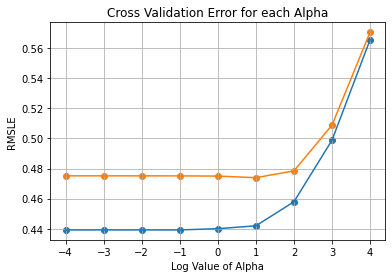

In [0]:
best_alpha = np.argmin(test_rmsle)

plt.plot(np.log10(alpha), train_rmsle, label='Train RMSLE')
plt.plot(np.log10(alpha), test_rmsle, label='Test RMSLE')

plt.scatter(np.log10(alpha), train_rmsle, label='Train RMSLE')
plt.scatter(np.log10(alpha), test_rmsle, label='Test RMSLE')

plt.title("Cross Validation Error for each Alpha")
plt.xlabel("Log Value of Alpha")
plt.ylabel("RMSLE")
plt.grid()
plt.show()

From the Above Plot of Train and Test RMSLE we can see that
* For alpha = 10 we are getting the best Test RMSLE Score
* Also there is a quite difference between Train and Test RMSLE Score, hence I think we might be overfitting here.

In [0]:
# Training for the Best Alpha Value 
model = Ridge(solver = 'lsqr',fit_intercept = False, alpha = alpha[best_alpha])
model.fit(X_train,y_train)
y_pred = np.expm1(model.predict(X_test))

print("Alpha : ", alpha[best_alpha])
train_score = rmsle_score(np.expm1(y_train),np.expm1(model.predict(X_train)))
test_score = rmsle_score(np.expm1(y_test),y_pred)
print("Train RMSLE : ",train_score)
print("Test RMSLE : ",test_score)

Alpha :  10
Train RMSLE :  0.44194628140031245
Test RMSLE :  0.47393280162673734


2. SVM Regressor

In [0]:
param = [0.0001,0.001,0.01,0.1,1,10,100]

train_rmsle_svr = []
test_rmsle_svr = []
for i in tqdm(param):
  model = SVR(C = i,max_iter=500)
  model.fit(X_train,y_train)
  y_pred = np.expm1(model.predict(X_test))

  rmsle_train = rmsle_score(np.expm1(y_train),np.expm1(model.predict(X_train)))
  train_rmsle_svr.append(rmsle_train)

  rmsle_test = rmsle_score(np.expm1(y_test),y_pred)
  test_rmsle_svr.append(rmsle_test)

  print("C : ",i)
  print("Train RMLSE : ",rmsle_train)
  print("Test RMSLE : ",rmsle_test)
  print()


 14%|█▍        | 1/7 [12:43<1:16:19, 763.18s/it]

C :  0.0001
Train RMLSE :  1.1856855164442457
Test RMSLE :  1.189815481075657



 29%|██▊       | 2/7 [25:42<1:04:00, 768.04s/it]

C :  0.001
Train RMLSE :  1.146878902915883
Test RMSLE :  1.1509665896977286



 43%|████▎     | 3/7 [38:15<50:54, 763.61s/it]  

C :  0.01
Train RMLSE :  0.9710655249419634
Test RMSLE :  0.9748140384875367



 57%|█████▋    | 4/7 [51:07<38:18, 766.06s/it]

C :  0.1
Train RMLSE :  0.91126644247203
Test RMSLE :  0.9150201798899613



 71%|███████▏  | 5/7 [1:01:27<24:04, 722.14s/it]

C :  1
Train RMLSE :  0.9635465691088329
Test RMSLE :  0.9668123962622746



 86%|████████▌ | 6/7 [1:11:19<11:23, 683.24s/it]

C :  10
Train RMLSE :  1.5851123511096268
Test RMSLE :  1.5884886495717772



100%|██████████| 7/7 [1:20:24<00:00, 689.18s/it]

C :  100
Train RMLSE :  2.3980299903035878
Test RMSLE :  2.4008576342487604



From the Above Result we can see that SVR performs worst than Ridge Regressor

3. LightGBM Regressor

In [0]:
lgb_model = LGBMRegressor(subsample=0.8)

params = {'learning_rate': uniform(0, 1),
          'n_estimators': sp_randint(700, 1500),
          'num_leaves': sp_randint(20, 200),
          'max_depth': sp_randint(2, 15),
          'min_child_weight': uniform(0, 2),
          'colsample_bytree': uniform(0, 1),
         }
lgb_regressor = RandomizedSearchCV(lgb_model, param_distributions=params, n_iter=10, cv=3, random_state=42, 
                                scoring='neg_root_mean_squared_error', verbose=10, return_train_score=True)

lgb_regressor = lgb_regressor.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=720, num_leaves=122 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=720, num_leaves=122, score=(train=-0.418, test=-0.495), total=14.2min
[CV] colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=720, num_leaves=122 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.7min remaining:    0.0s


[CV]  colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=720, num_leaves=122, score=(train=-0.419, test=-0.494), total=14.2min
[CV] colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=720, num_leaves=122 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 33.3min remaining:    0.0s


[CV]  colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=720, num_leaves=122, score=(train=-0.417, test=-0.492), total=14.2min
[CV] colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=799, num_leaves=123 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 50.0min remaining:    0.0s


[CV]  colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=799, num_leaves=123, score=(train=-0.456, test=-0.477), total=17.5min
[CV] colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=799, num_leaves=123 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 70.3min remaining:    0.0s


[CV]  colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=799, num_leaves=123, score=(train=-0.457, test=-0.474), total=17.4min
[CV] colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=799, num_leaves=123 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 90.5min remaining:    0.0s


[CV]  colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=799, num_leaves=123, score=(train=-0.457, test=-0.475), total=17.3min
[CV] colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1113, num_leaves=57 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 110.6min remaining:    0.0s


[CV]  colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1113, num_leaves=57, score=(train=-0.587, test=-0.590), total= 7.5min
[CV] colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1113, num_leaves=57 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 119.3min remaining:    0.0s


[CV]  colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1113, num_leaves=57, score=(train=-0.588, test=-0.587), total= 7.5min
[CV] colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1113, num_leaves=57 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 128.0min remaining:    0.0s


[CV]  colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1113, num_leaves=57, score=(train=-0.588, test=-0.589), total= 7.5min
[CV] colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, min_child_weight=0.6084844859190754, n_estimators=721, num_leaves=108 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 136.7min remaining:    0.0s


[CV]  colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, min_child_weight=0.6084844859190754, n_estimators=721, num_leaves=108, score=(train=-0.585, test=-0.591), total= 2.3min
[CV] colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, min_child_weight=0.6084844859190754, n_estimators=721, num_leaves=108 
[CV]  colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, min_child_weight=0.6084844859190754, n_estimators=721, num_leaves=108, score=(train=-0.594, test=-0.597), total= 2.3min
[CV] colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, min_child_weight=0.6084844859190754, n_estimators=721, num_leaves=108 
[CV]  colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, min_child_weight=0.6084844859190754, n_estimators=721, num_leaves=108, score=(train=-0.581, test=-0.585), total= 2.3min
[CV] colsample_bytree=0.29122914019

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 424.9min finished


In [0]:
best_params = lgb_regressor.best_params_
print(best_params)

{'colsample_bytree': 0.230893825622149, 'learning_rate': 0.24102546602601171, 'max_depth': 13, 'min_child_weight': 0.24407646968955765, 'n_estimators': 1208, 'num_leaves': 27}


In [0]:
model = LGBMRegressor(**best_params, subsample=0.9, random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.230893825622149, importance_type='split',
              learning_rate=0.24102546602601171, max_depth=13,
              min_child_samples=20, min_child_weight=0.24407646968955765,
              min_split_gain=0.0, n_estimators=1208, n_jobs=-1, num_leaves=27,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=0.9, subsample_for_bin=200000,
              subsample_freq=0)

In [0]:
y_pred = np.expm1(model.predict(X_test))
test_score = rmsle_score(np.expm1(y_test),y_pred)
print("Test RMSLE : ",test_score)

Test RMSLE :  0.462528130538227


In [0]:
file = open("lgbm_model","wb")
pickle.dump(model,file)
file.close()

## Applying on TF-IDF Values of Text

In [0]:
Vectorizer = TfidfVectorizer(ngram_range = (1,3),min_df=25,max_features=50000,dtype = np.float32)
Vectorizer.fit(train['preprocess_name'].values)

train_name_tfidf = Vectorizer.transform(train['preprocess_name'].values)
test_name_tfidf = Vectorizer.transform(test['preprocess_name'].values)

print("After Vectorization :")
print(train_name_tfidf.shape)
print(test_name_tfidf.shape)

After Vectorization :
(1111239, 30635)
(370634, 30635)


In [0]:
Vectorizer = TfidfVectorizer(ngram_range = (1,3),min_df=30,max_features=100000,dtype = np.float32)
Vectorizer.fit(train['preprocess_desc'].values)

train_desc_tfidf = Vectorizer.transform(train['preprocess_desc'].values)
test_desc_tfidf = Vectorizer.transform(test['preprocess_desc'].values)

print("After Vectorization :")
print(train_desc_tfidf.shape)
print(test_desc_tfidf.shape)

After Vectorization :
(1111239, 100000)
(370634, 100000)


In [0]:
file = open("train_name_tfidf","wb")
pickle.dump(train_name_tfidf,file)
file.close()

file = open("test_name_tfidf","wb")
pickle.dump(test_name_tfidf,file)
file.close()

file = open("train_desc_tfidf","wb")
pickle.dump(train_desc_tfidf,file)
file.close()

file = open("test_desc_tfidf","wb")
pickle.dump(test_desc_tfidf,file)
file.close()

### Concatenating/Stacking all the Features

In [0]:
X_train_tfidf = hstack((train_name_tfidf,train_desc_tfidf,train_brand,train_category_name,
                  train_dummies)).tocsr().astype('float32')
X_test_tfidf = hstack((test_name_tfidf,test_desc_tfidf,test_brand,test_category_name,
                  test_dummies)).tocsr().astype('float32')

print("X_train Shape : ",X_train_tfidf.shape)
print("y_train Shape : ",y_train_tfidf.shape)
print("X_test Shape : ",X_test_tfidf.shape)
print("y_test Shape : ",y_test_tfidf.shape)

X_train Shape :  (1111239, 136019)
y_train Shape :  (1111239,)
X_test Shape :  (370634, 136019)
y_test Shape :  (370634,)


In [0]:
file = open("X_train_tfidf","wb")
pickle.dump(X_train_tfidf,file)
file.close()

file = open("X_test_tfidf","wb")
pickle.dump(X_test_tfidf,file)
file.close()

In [0]:
file = open("y_train_tfidf","wb")
pickle.dump(y_train_tfidf,file)
file.close()

file = open("y_test_tfidf","wb")
pickle.dump(y_test_tfidf,file)
file.close()

### ML Models

In [0]:
file = open("X_train_tfidf","rb")
X_train_tfidf = pickle.load(file)
file.close()

file = open("X_test_tfidf","rb")
X_test_tfidf = pickle.load(file)
file.close()

file = open("y_train_tfidf","rb")
y_train_tfidf = pickle.load(file)
file.close()

file = open("y_test_tfidf","rb")
y_test_tfidf = pickle.load(file)
file.close()

1. Ridge Regressor

In [0]:
alpha = [0.0001,0.001,0.01,0.1,1,10,100,1000,10000]
train_rmsle = []
test_rmsle = []
for i in alpha:
  model = Ridge(solver = "lsqr", fit_intercept=False,alpha = i)
  model.fit(X_train_tfidf, y_train_tfidf)
  y_pred = np.expm1(model.predict(X_test_tfidf))

  rmsle_train = rmsle_score(np.expm1(y_train_tfidf),np.expm1(model.predict(X_train_tfidf)))
  train_rmsle.append(rmsle_train)

  rmsle_test = rmsle_score(np.expm1(y_test_tfidf),y_pred)
  test_rmsle.append(rmsle_test)

  print("Alpha : ",i)
  print("Train RMLSE : ",rmsle_train)
  print("Test RMSLE : ",rmsle_test)
  print()

Alpha :  0.0001
Train RMLSE :  0.46081648401566516
Test RMSLE :  0.4763449157912248

Alpha :  0.001
Train RMLSE :  0.4608164840727942
Test RMSLE :  0.47634477852147117

Alpha :  0.01
Train RMLSE :  0.4608164840901191
Test RMSLE :  0.4763433929908403

Alpha :  0.1
Train RMLSE :  0.460816631950732
Test RMSLE :  0.47632970718435835

Alpha :  1
Train RMLSE :  0.46083165018893485
Test RMSLE :  0.47620769381899525

Alpha :  10
Train RMLSE :  0.4658397511327369
Test RMSLE :  0.47867408853971893

Alpha :  100
Train RMLSE :  0.4930396827514537
Test RMSLE :  0.5002915717749749

Alpha :  1000
Train RMLSE :  0.5578016547928514
Test RMSLE :  0.5607288389818227

Alpha :  10000
Train RMLSE :  0.6367958882117589
Test RMSLE :  0.6383552431087544



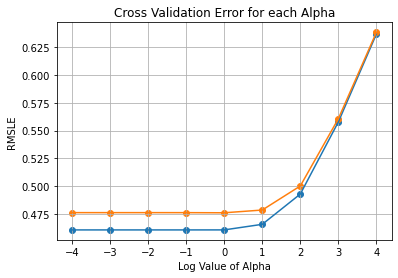

In [0]:
best_alpha = np.argmin(test_rmsle)

plt.plot(np.log10(alpha), train_rmsle, label='Train RMSLE')
plt.plot(np.log10(alpha), test_rmsle, label='Test RMSLE')

plt.scatter(np.log10(alpha), train_rmsle, label='Train RMSLE')
plt.scatter(np.log10(alpha), test_rmsle, label='Test RMSLE')

plt.title("Cross Validation Error for each Alpha")
plt.xlabel("Log Value of Alpha")
plt.ylabel("RMSLE")
plt.grid()
plt.show()

In [0]:
# Training for the Best Alpha Value 
model = Ridge(solver = 'lsqr',fit_intercept = False, alpha = alpha[best_alpha])
model.fit(X_train_tfidf,y_train_tfidf)
y_pred = np.expm1(model.predict(X_test_tfidf))

print("Alpha : ", alpha[best_alpha])
train_score = rmsle_score(np.expm1(y_train_tfidf),np.expm1(model.predict(X_train_tfidf)))
test_score = rmsle_score(np.expm1(y_test_tfidf),y_pred)
print("Train RMSLE : ",train_score)
print("Test RMSLE : ",test_score)

Alpha :  1
Train RMSLE :  0.46083165018893485
Test RMSLE :  0.47620769381899525


2. LGBM Regressor

In [0]:
lgb_model = LGBMRegressor(subsample=0.8)

params = {'learning_rate': uniform(0, 1),
          'n_estimators': sp_randint(700, 1500),
          'num_leaves': sp_randint(20, 200),
          'max_depth': sp_randint(2, 15),
          'min_child_weight': uniform(0, 2),
          'colsample_bytree': uniform(0, 1),
         }
lgb_regressor = RandomizedSearchCV(lgb_model, param_distributions=params, n_iter=8, cv=3, random_state=42, 
                                scoring='neg_root_mean_squared_error', verbose=10, return_train_score=True)

lgb_regressor = lgb_regressor.fit(X_train_tfidf, y_train_tfidf)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=720, num_leaves=122 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=720, num_leaves=122, score=(train=-0.403, test=-0.507), total=14.4min
[CV] colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=720, num_leaves=122 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.5min remaining:    0.0s


[CV]  colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=720, num_leaves=122, score=(train=-0.405, test=-0.507), total=13.8min
[CV] colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=720, num_leaves=122 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 32.3min remaining:    0.0s


[CV]  colsample_bytree=0.3745401188473625, learning_rate=0.9507143064099162, max_depth=12, min_child_weight=1.5593820005455385, n_estimators=720, num_leaves=122, score=(train=-0.404, test=-0.510), total=13.9min
[CV] colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=799, num_leaves=123 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 48.3min remaining:    0.0s


[CV]  colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=799, num_leaves=123, score=(train=-0.450, test=-0.476), total=18.1min
[CV] colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=799, num_leaves=123 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 68.7min remaining:    0.0s


[CV]  colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=799, num_leaves=123, score=(train=-0.450, test=-0.476), total=18.1min
[CV] colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=799, num_leaves=123 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 89.2min remaining:    0.0s


[CV]  colsample_bytree=0.44583275285359114, learning_rate=0.09997491581800289, max_depth=12, min_child_weight=1.7323522915498704, n_estimators=799, num_leaves=123, score=(train=-0.450, test=-0.476), total=18.5min
[CV] colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1113, num_leaves=57 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed: 110.1min remaining:    0.0s


[CV]  colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1113, num_leaves=57, score=(train=-0.587, test=-0.588), total= 7.8min
[CV] colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1113, num_leaves=57 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 118.8min remaining:    0.0s


[CV]  colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1113, num_leaves=57, score=(train=-0.587, test=-0.588), total= 7.7min
[CV] colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1113, num_leaves=57 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 127.5min remaining:    0.0s


[CV]  colsample_bytree=0.7080725777960455, learning_rate=0.020584494295802447, max_depth=3, min_child_weight=1.4439975445336495, n_estimators=1113, num_leaves=57, score=(train=-0.587, test=-0.588), total= 7.9min
[CV] colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, min_child_weight=0.6084844859190754, n_estimators=721, num_leaves=108 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed: 136.3min remaining:    0.0s


[CV]  colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, min_child_weight=0.6084844859190754, n_estimators=721, num_leaves=108, score=(train=-0.579, test=-0.587), total= 2.0min
[CV] colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, min_child_weight=0.6084844859190754, n_estimators=721, num_leaves=108 
[CV]  colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, min_child_weight=0.6084844859190754, n_estimators=721, num_leaves=108, score=(train=-0.581, test=-0.588), total= 1.9min
[CV] colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, min_child_weight=0.6084844859190754, n_estimators=721, num_leaves=108 
[CV]  colsample_bytree=0.0007787658410143283, learning_rate=0.9922115592912175, max_depth=2, min_child_weight=0.6084844859190754, n_estimators=721, num_leaves=108, score=(train=-0.580, test=-0.588), total= 1.9min
[CV] colsample_bytree=0.29122914019

[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed: 312.2min finished


In [0]:
best_params = lgb_regressor.best_params_
print(best_params)

{'colsample_bytree': 0.2912291401980419, 'learning_rate': 0.6118528947223795, 'max_depth': 11, 'min_child_weight': 0.09333132642723085, 'n_estimators': 1399, 'num_leaves': 34}


In [0]:
model = LGBMRegressor(**best_params, subsample=0.8, random_state=42, n_jobs=-1)
model.fit(X_train_tfidf, y_train_tfidf)

LGBMRegressor(boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.2912291401980419, importance_type='split',
              learning_rate=0.6118528947223795, max_depth=11,
              min_child_samples=20, min_child_weight=0.09333132642723085,
              min_split_gain=0.0, n_estimators=1399, n_jobs=-1, num_leaves=34,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=0.8, subsample_for_bin=200000,
              subsample_freq=0)

In [0]:
y_pred = np.expm1(model.predict(X_test_tfidf))
test_score = rmsle_score(np.expm1(y_test_tfidf),y_pred)
print("Test RMSLE : ",test_score)

Test RMSLE :  0.4624652701321925


In [2]:
from prettytable import PrettyTable

x = PrettyTable()

x.field_names = ["Model", "Test RMSLE"]

x.add_row(["Ridge Regressor with BOW Features",0.4739])
x.add_row(["LGBMRegressor with BOW Features",0.4625])
x.add_row(["SVR with BOW Features",0.9150])
x.add_row(["Ridge Regressor with TF-IDF Features",0.4762])
x.add_row(["LGBMRegressor with TF-IDF Features",0.4624])

print(x)

+--------------------------------------+------------+
|                Model                 | Test RMSLE |
+--------------------------------------+------------+
|  Ridge Regressor with BOW Features   |   0.4739   |
|   LGBMRegressor with BOW Features    |   0.4625   |
|        SVR with BOW Features         |   0.915    |
| Ridge Regressor with TF-IDF Features |   0.4762   |
|  LGBMRegressor with TF-IDF Features  |   0.4624   |
+--------------------------------------+------------+


As you can see from the above table that LightGBM Regressor with TF-IDF features perfroms the best among the other traditional Models but we can perfrom better using Deep Learning Models